# Visualise signal analysis

This notebook demonstrates the different methods for extracting the frequency from a signal. The signal is a ground truth signal from the dataset. The signal is preprocessed by filtering and normalizing it. The frequency is then extracted using the FFT, peak counting, and crossing point methods. The results are compared to the ground truth frequency.

In [21]:
from respiration.dataset import VitalCamSet

dataset = VitalCamSet()

subject = 'Proband15'
scenario = '101_natural_lighting'

In [22]:
hyperparameters = {
    'quality_level': 0.1,
    'quality_level_rv': 0.05,
    'filter_lowpass': 0.1,
    'filter_highpass': 0.6,
}

In [23]:
gt_signal = dataset.get_breathing_signal(subject, scenario)
gt_sample_rate = 30

## Signal Preprocessing

In [24]:
import respiration.analysis as analysis

signal_filter = analysis.butterworth_filter(
    gt_signal,
    gt_sample_rate,
    lowpass=hyperparameters['filter_lowpass'],
    highpass=hyperparameters['filter_highpass'],
)
signal_normalization = analysis.normalize_signal(signal_filter)

processed_signal = signal_normalization

In [25]:
import respiration.utils as utils

figure_dir = utils.dir_path('outputs', 'figures', 'metrics', mkdir=True)

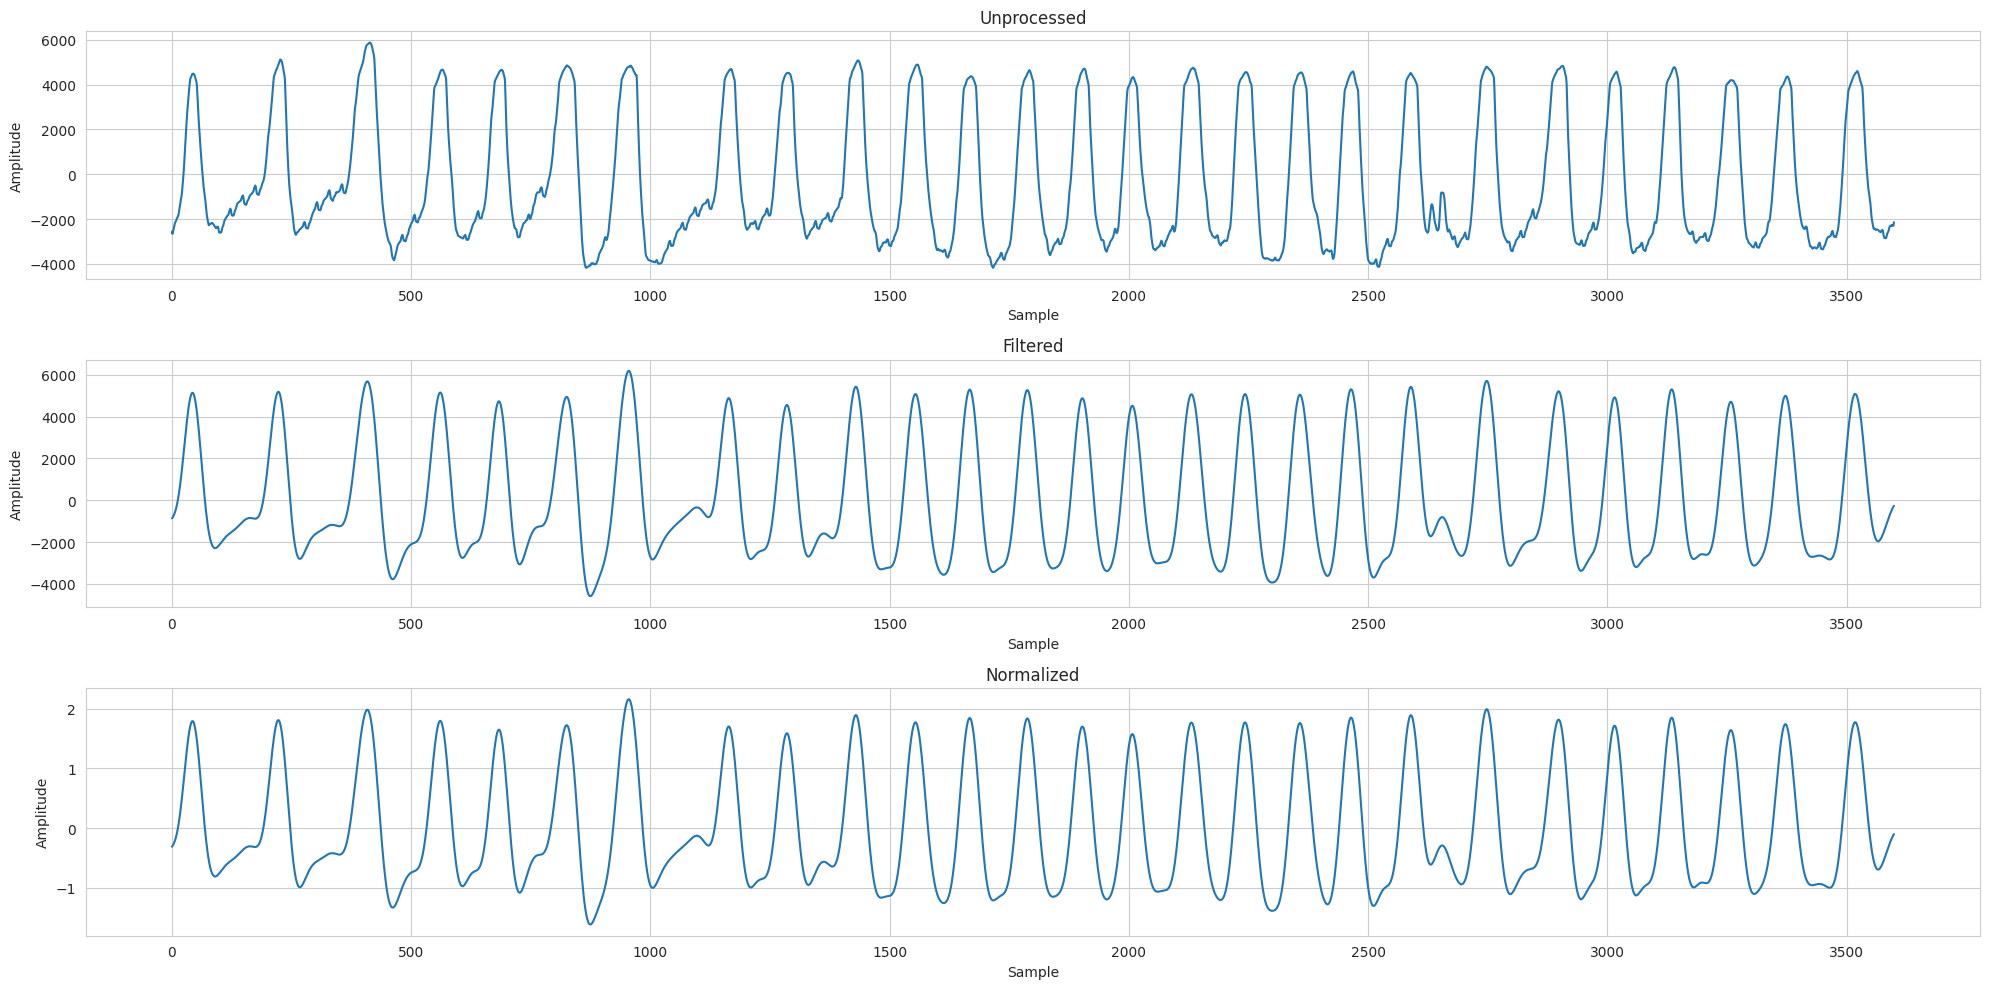

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(gt_signal)
axs[0].set_title('Unprocessed')
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Amplitude')

axs[1].plot(signal_filter)
axs[1].set_title('Filtered')
axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Amplitude')

axs[2].plot(signal_normalization)
axs[2].set_title('Normalized')
axs[2].set_xlabel('Sample')
axs[2].set_ylabel('Amplitude')

fig.tight_layout()

utils.savefig(fig, figure_dir, 'signal_preprocessing')

plt.show()

## Frequency Extraction with FFT

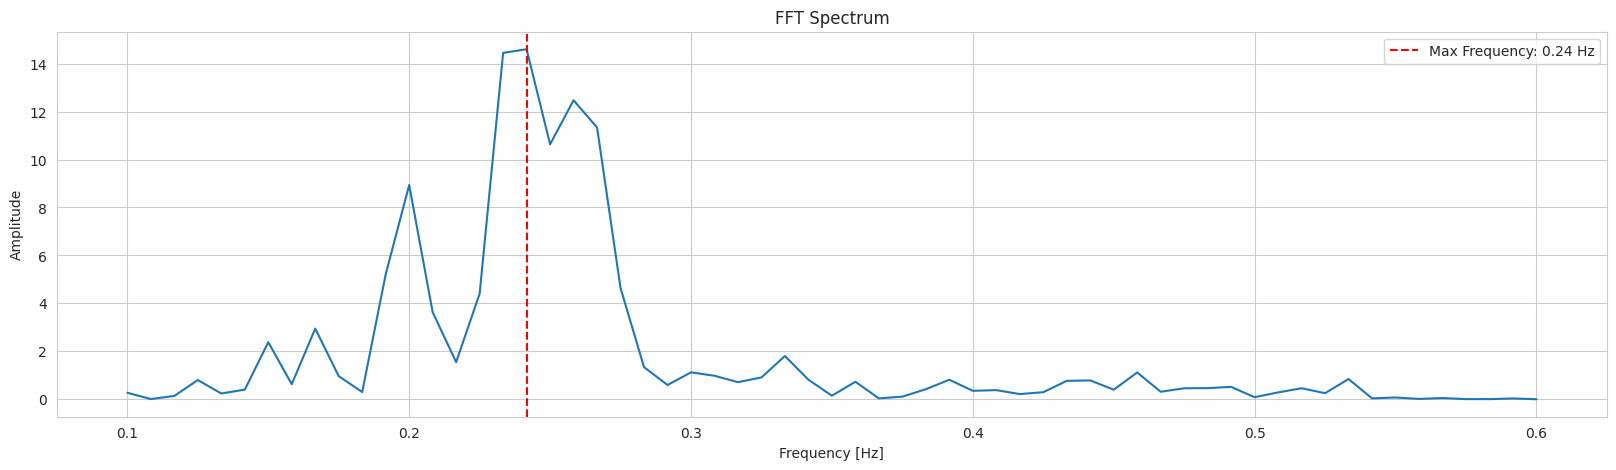

In [27]:
from respiration.analysis import *

frequencies, fft_result = filtered_periodogram(
    processed_signal,
    gt_sample_rate,
    min_freq=hyperparameters['filter_lowpass'],
    max_freq=hyperparameters['filter_highpass']
)

fig = plt.figure(figsize=(20, 5))

# Plot the FFT spectrum
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Mark the max frequency
max_freq = frequencies[np.argmax(np.abs(fft_result))]
plt.axvline(max_freq, color='r', linestyle='--', label=f'Max Frequency: {max_freq:.2f} Hz')
plt.legend()

utils.savefig(fig, figure_dir, 'psd')

plt.show()

## Frequency Extraction with Peak Counting

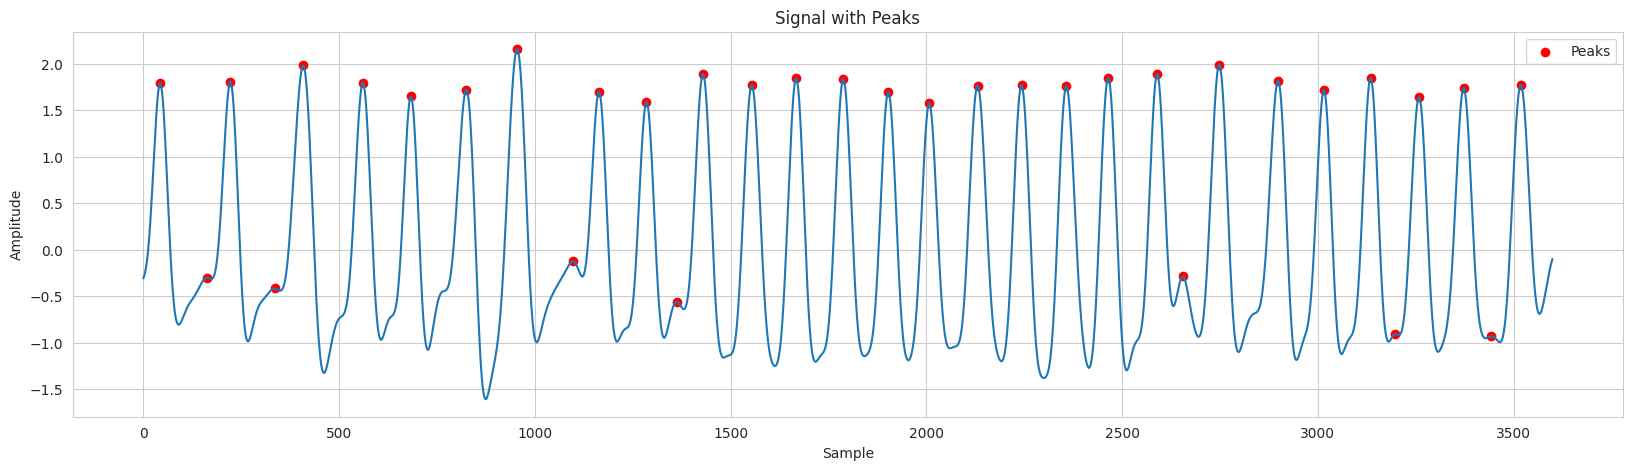

In [28]:
peaks = find_peaks(processed_signal, gt_sample_rate, min_frequency=0.08)

fig = plt.figure(figsize=(20, 5))

# Plot the signal with the peaks
plt.plot(processed_signal)
plt.scatter(peaks, processed_signal[peaks], color='r', label='Peaks')
plt.title('Signal with Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

utils.savefig(fig, figure_dir, 'peaks')

plt.show()

In [29]:
print(f'Number of Peaks: {len(peaks)}')
pc_frequency = len(peaks) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {pc_frequency:.2f} Hz')

Number of Peaks: 34
Frequency: 0.28 Hz


## Frequency Extraction with Crossing Point

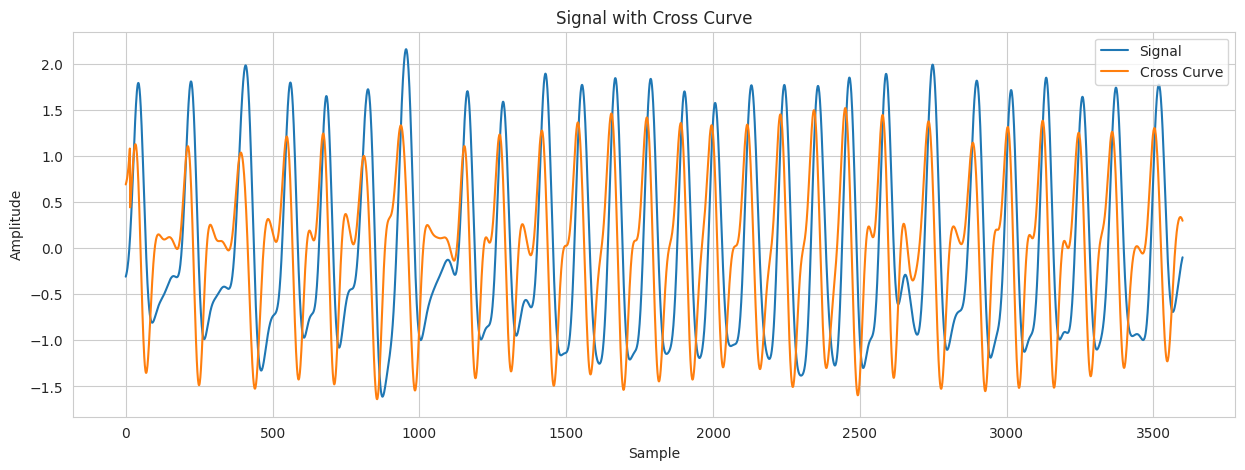

In [30]:
cross_curve = build_cross_curve(processed_signal, gt_sample_rate)

# Plot the signal with the cross curve
plt.figure(figsize=(15, 5))
plt.plot(processed_signal, label='Signal')
plt.plot(cross_curve, label='Cross Curve')
plt.title('Signal with Cross Curve')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

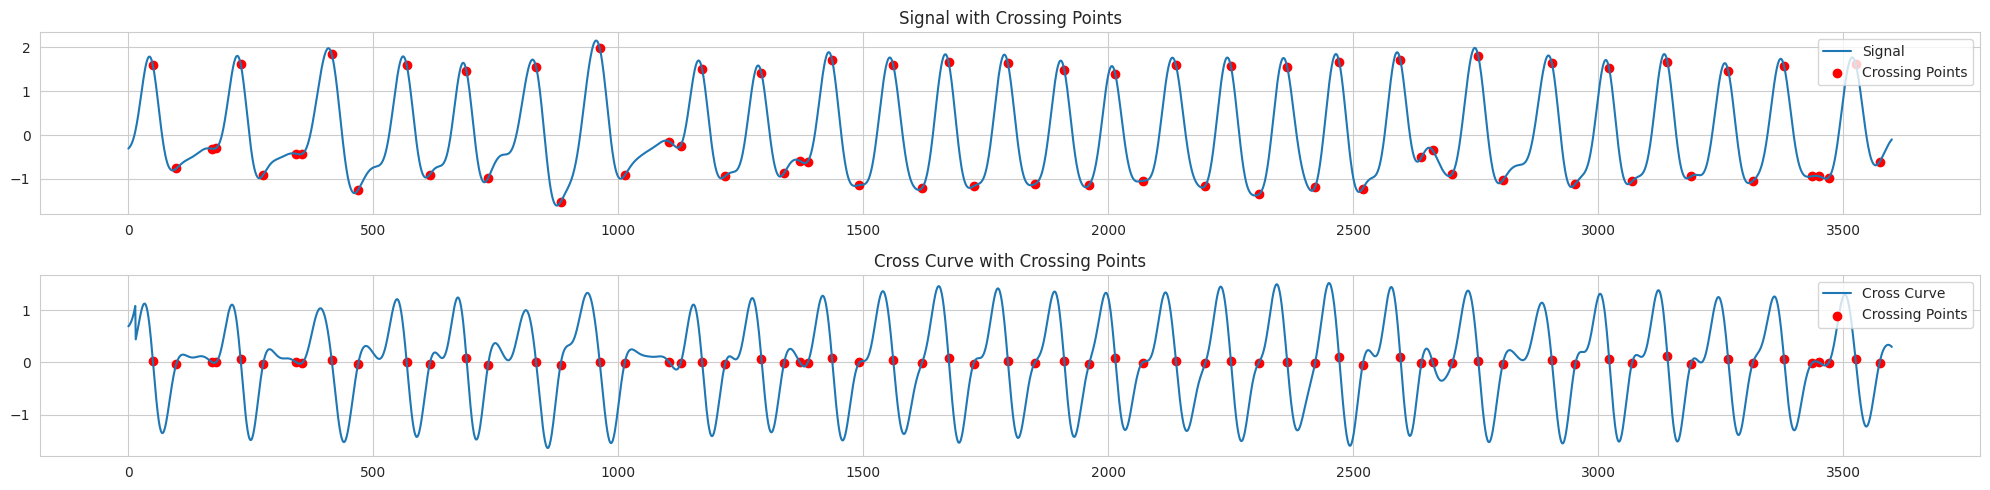

In [31]:
cross_points = find_crossing_points(cross_curve)

cp_fig, axs = plt.subplots(2, 1, figsize=(20, 5))

# Plot the signal with the crossing points
signal_ax = axs[0]
signal_ax.set_title('Signal with Crossing Points')
signal_ax.plot(processed_signal, label='Signal')
signal_ax.scatter(cross_points, processed_signal[cross_points], color='r', label='Crossing Points')
signal_ax.legend(loc='upper right')

# Plot the signal with the crossing points
cross_curve_ax = axs[1]
cross_curve_ax.set_title('Cross Curve with Crossing Points')
cross_curve_ax.plot(cross_curve, label='Cross Curve')
cross_curve_ax.scatter(cross_points, cross_curve[cross_points], color='r', label='Crossing Points')
cross_curve_ax.legend(loc='upper right')

cp_fig.tight_layout()

utils.savefig(cp_fig, figure_dir, 'crossing_points')

plt.show()

In [32]:
print(f'Number of Crossing Points: {len(cross_points)}')
cp_frequency = (len(cross_points) / 2) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {cp_frequency:.2f} Hz')

Number of Crossing Points: 66
Frequency: 0.28 Hz


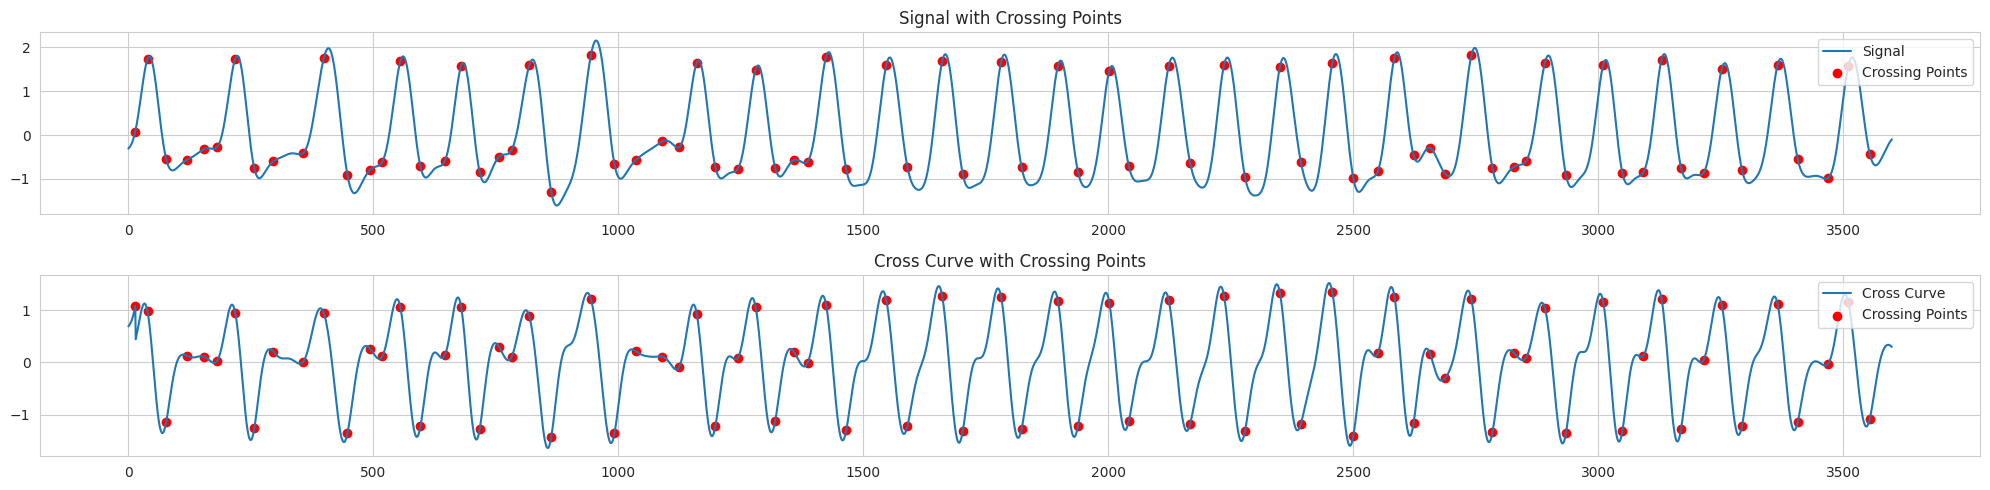

In [33]:
cross_points_nfcp = find_crossing_points_nfcp(cross_curve, gt_sample_rate, quality_level=0.5)

nfcp_fig, axs = plt.subplots(2, 1, figsize=(20, 5))

# Plot the signal with the crossing points
signal_ax = axs[0]
signal_ax.set_title('Signal with Crossing Points')
signal_ax.plot(processed_signal, label='Signal')
signal_ax.scatter(cross_points_nfcp, processed_signal[cross_points_nfcp], color='r', label='Crossing Points')
signal_ax.legend(loc='upper right')

# Plot the signal with the crossing points
cross_curve_ax = axs[1]
cross_curve_ax.set_title('Cross Curve with Crossing Points')
cross_curve_ax.plot(cross_curve, label='Cross Curve')
cross_curve_ax.scatter(cross_points_nfcp, cross_curve[cross_points_nfcp], color='r', label='Crossing Points')
cross_curve_ax.legend(loc='upper right')

nfcp_fig.tight_layout()

utils.savefig(nfcp_fig, figure_dir, 'crossing_points_nfcp')

plt.show()

In [34]:
print(f'Number of Crossing Points: {len(cross_points_nfcp)}')
nfcp_frequency = (len(cross_points_nfcp) / 2) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {nfcp_frequency:.2f} Hz')

Number of Crossing Points: 79
Frequency: 0.33 Hz


## Overall Comparison

In [35]:
import respiration.utils as utils

gt_frequency = {
    'unprocessed_signal': {
        'PSD': frequency_from_psd(gt_signal, gt_sample_rate),
        'PC': frequency_from_peaks(gt_signal, gt_sample_rate),
        'CP': frequency_from_crossing_point(gt_signal, gt_sample_rate),
        'NFCP': frequency_from_nfcp(gt_signal, gt_sample_rate)
    },
    'processed_signal': {
        'PSD': frequency_from_psd(processed_signal, gt_sample_rate),
        'PC': frequency_from_peaks(processed_signal, gt_sample_rate),
        'CP': frequency_from_crossing_point(processed_signal, gt_sample_rate),
        'NFCP': frequency_from_nfcp(processed_signal, gt_sample_rate)
    }
}
utils.pretty_print(gt_frequency)

{
  "processed_signal": {
    "CP": 0.275,
    "NFCP": 0.32916666666666666,
    "PC": 0.016666666666666666,
    "PSD": 0.24166666666666667
  },
  "unprocessed_signal": {
    "CP": 0.42916666666666664,
    "NFCP": 0.3541666666666667,
    "PC": 0.016666666666666666,
    "PSD": 0.24166666666666667
  }
}
